In [3]:
from sklearn import tree
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

from IPython.display import HTML
style = "<style>svg{width:50% !important; height:50% !important;}</style>"

In [5]:
titanic_data = pd.read_csv('train.csv')

In [50]:
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
# cheching for null values
titanic_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
## Data Preprocessing
# dropping useless variables
X = titanic_data.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'], axis = 1)

# split string variables to integer by dummy variables
X = pd.get_dummies(X)

# fill NA falues in Age variable by median
X = X.fillna({'Age': X.Age.median()})

# Pred. variable
y = titanic_data.Survived

X.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,1


In [8]:
# initial DT
clf = tree.DecisionTreeClassifier(criterion = 'entropy')

# fit model
clf.fit(X,y)
clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

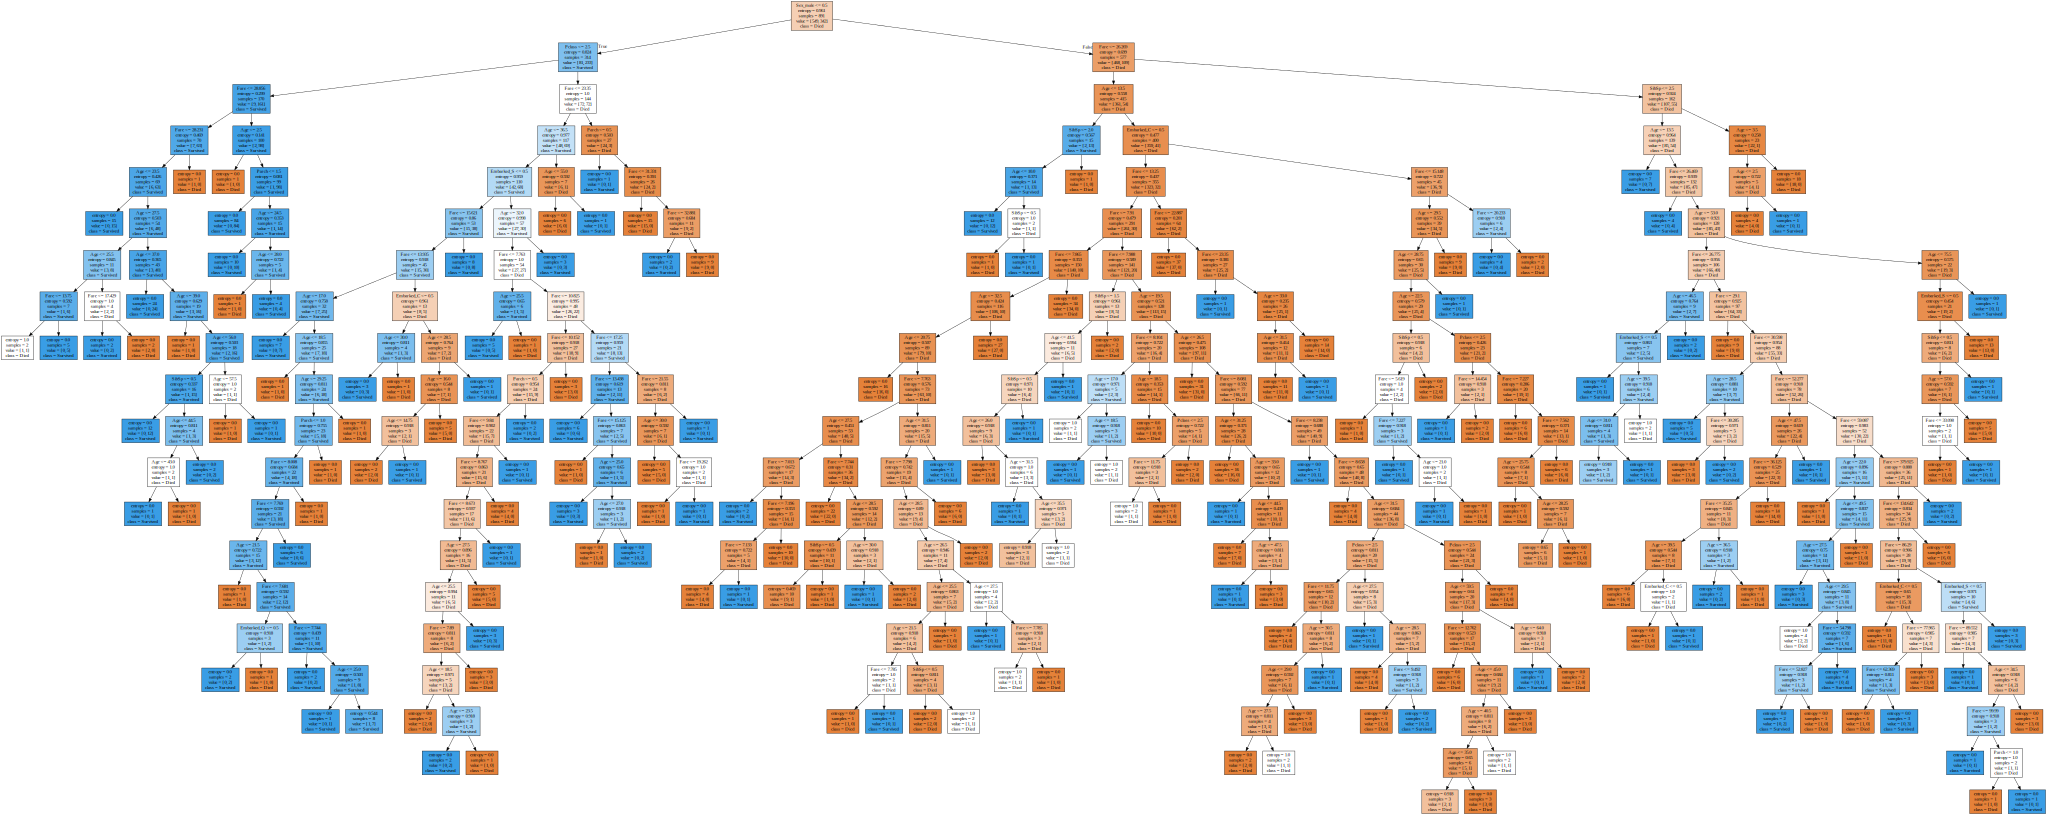

In [9]:
# Overfitting version
graph = Source(tree.export_graphviz(clf, out_file=None,
               feature_names=list(X), class_names=["Died", "Survived"],
               filled = True))

display(SVG(graph.pipe(format='svg')))

In [10]:
# Split data to train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [11]:
# learn model on train set
clf.fit(X_train, y_train)

# check score on train set
clf.score(X_train, y_train)

0.9798657718120806

In [12]:
# check score on test set
clf.score(X_test, y_test)

0.7728813559322034

In [13]:
# change the max depth on the tree
clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth=3)

# learn model on train set
clf.fit(X_train, y_train)

# check score on train set
clf.score(X_train, y_train)

0.8238255033557047

In [14]:
# check score on test set
clf.score(X_test, y_test)

0.8203389830508474

In [15]:
# 2.4 Обучение, переобучение, недообучение и кросвалидация

# create list of max_depth range 
max_depth_values = range(1,100)
score_data = pd.DataFrame()

In [16]:
# interate amoung the max_depth and save results in empty data frame 
for max_depth in max_depth_values:
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    clf.fit(X_train,y_train)
    train_score = clf.score(X_train,y_train)
    test_score = clf.score(X_test, y_test)
    
    temp_score_data = pd.DataFrame({'max_depth':[max_depth], 
                                    'train_score':[train_score], 
                                    'test_score':[test_score]})
    
    score_data = score_data.append(temp_score_data)

score_data.head()

,max_depth,train_score,test_score
0,1,0.781879,0.796610
0,2,0.805369,0.776271
0,3,0.823826,0.820339
0,4,0.833893,0.823729
0,5,0.840604,0.810169


In [17]:
# Preprocess data for viz
score_data_long = pd.melt(score_data, id_vars=['max_depth'],
                         value_vars=['train_score', 'test_score'],
                         var_name='set_type', value_name='score')
score_data_long.head()

,max_depth,set_type,score
0,1,train_score,0.781879
1,2,train_score,0.805369
2,3,train_score,0.823826
3,4,train_score,0.833893
4,5,train_score,0.840604


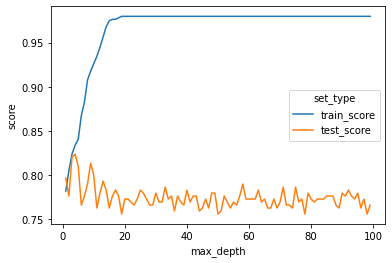

In [18]:
# Visualize the score data via seaborn
sns.lineplot(x='max_depth', y='score', hue='set_type', data=score_data_long)


In [20]:
## Cross-Validation 
from sklearn.model_selection import cross_val_score

max_depth_values = range(1,100)
score_data = pd.DataFrame()

for max_depth in max_depth_values:
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    clf.fit(X_train,y_train)
    train_score = clf.score(X_train,y_train)
    test_score = clf.score(X_test, y_test)
    
    mean_cross_score = cross_val_score(clf, X_train, y_train, cv=5).mean()
    
    temp_score_data = pd.DataFrame({'max_depth':[max_depth], 
                                    'train_score':[train_score], 
                                    'test_score':[test_score],
                                    'cross_score':[mean_cross_score]})
    
    score_data = score_data.append(temp_score_data)

score_data.head()

,max_depth,train_score,test_score,cross_score
0,1,0.781879,0.796610,0.781961
0,2,0.805369,0.776271,0.770196
0,3,0.823826,0.820339,0.790322
0,4,0.833893,0.823729,0.788627
0,5,0.840604,0.806780,0.800392


In [21]:
# Preprocess data for viz
score_data_long = pd.melt(score_data, id_vars=['max_depth'],
                         value_vars=['train_score', 'test_score', 'cross_score'],
                         var_name='set_type', value_name='score')
score_data_long.head()

,max_depth,set_type,score
0,1,train_score,0.781879
1,2,train_score,0.805369
2,3,train_score,0.823826
3,4,train_score,0.833893
4,5,train_score,0.840604


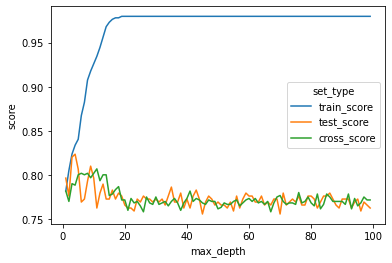

In [23]:
# Visualize the score data via seaborn
sns.lineplot(x='max_depth', y='score', hue='set_type', data=score_data_long)

In [34]:
score_data_long.query("set_type == 'cross_score'").sort_values('score', ascending=False).head(1)

,max_depth,set_type,score
208,11,cross_score,0.807073


In [31]:
best_clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=11)
best_clf.fit(X_train, y_train)
best_clf.score(X_test, y_test)

0.7728813559322034